<a href="https://colab.research.google.com/github/a3d2ddk/Prenith-and-Drew-Augmented-Reality-PyTorch3D/blob/main/Augmented_reality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This code is not required but will allow you to be able to skip the pip installs in the next two cells
'''
Run only once
'''
import os, sys
from google.colab import drive
drive.mount('/content/drive')
nb_path = '/content/notebooks'
os.symlink('/content/drive/My Drive/comp_vision_libs', nb_path)
sys.path.insert(0,nb_path)

In [ ]:
!pip install --target=$nb_path torch torchvision torchaudio

In [23]:
calibration_dir = ""

In [ ]:
import os
import sys
import torch
from pathlib import Path

def in_colab() -> bool:
    try:
        import google.colab  # noqa: F401
        return True
    except Exception:
        return False

REPO_URL  = "https://github.com/a3d2ddk/Prenith-and-Drew-Augmented-Reality-PyTorch3D.git"

if in_colab():
  calibration_dir = "/content/Prenith-and-Drew-Augmented-Reality-PyTorch3D/"
  print("Running in Colab")
  if not Path("/content/Prenith-and-Drew-Augmented-Reality-PyTorch3D/").exists():
    !git clone {REPO_URL}
else:
  calibration_dir = ""

print(f"Calibration directory: {calibration_dir}")


need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if Path(calibration_dir + "pytorch3d-wheel").exists():

    if torch.__version__.startswith(("1.13.", "2.0.")) and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [24]:
import os
import sys
import subprocess
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm.notebook import tqdm
from pytorch3d.io import load_obj, load_ply, load_objs_as_meshes
from pytorch3d.structures import Meshes
from pytorch3d.transforms import Rotate, Translate
from pytorch3d.renderer import (
    FoVPerspectiveCameras,
    PerspectiveCameras,
    look_at_view_transform,
    look_at_rotation,
    camera_position_from_spherical_angles,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    BlendParams,
    SoftSilhouetteShader,
    SoftPhongShader,
    HardPhongShader,
    PointLights,
    DirectionalLights,
    Materials,
    TexturesUV,
    TexturesVertex,
)
from pytorch3d.renderer.cameras import CamerasBase
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib

sys.path.append(os.path.abspath(''))


In [25]:
def download_cow_mesh():
    say("step", "Creating data/cow_mesh directory...")
    os.makedirs("data/cow_mesh", exist_ok=True)

    urls = [
        "https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj",
        "https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl",
        "https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow_texture.png",
    ]

    for url in urls:
        fname = os.path.basename(url)
        out = os.path.join("data/cow_mesh", fname)
        if not os.path.exists(out):
            say("info", f"Downloading {fname} ...")
            subprocess.run(["wget", "-q", "-O", out, url], check=True)
            say("ok", f"Saved → {out}")
        else:
            say("warn", f"{fname} already exists, skipping.")

    say("ok", "Cow mesh download complete!")

def make_phong_renderer(W, H, device):
    raster_settings = RasterizationSettings(
        image_size=(W, H),
        blur_radius=0.0,
        faces_per_pixel=1,
    )
    # No cameras/lights bound here; we’ll pass them at render time.
    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(raster_settings=raster_settings),
        shader=SoftPhongShader(device=device)
    )
    return renderer

def set_renderer_state(renderer, *, cameras=None, lights=None):
    if cameras is not None:
        renderer.rasterizer.cameras = cameras
        renderer.shader.cameras     = cameras
    if lights is not None:
        renderer.shader.lights      = lights

def overlay_axes_p3d(
    rgb: np.ndarray,
    cameras,
    height: int,
    width: int,
    world_origin=(0.0, 0.0, 0.0),
    axis_len=0.5,
    draw_world_axes=True,
    draw_camera_axes=True,
    cam_axis_len=0.5,
    title=None,
):
    """
    Overlay +X (red), +Y (green), +Z (blue) axes on top of an image.

    Args:
      rgb: (H,W,3) float image in [0,1] you rendered with `cameras`.
      cameras: a PyTorch3D Cameras object (PerspectiveCameras or FoVPerspectiveCameras).
      height, width: image size used for rendering.
      world_origin: 3-tuple; where to anchor the world axes in world coordinates.
      axis_len: length (in world units) of each world-axis arm.
      draw_world_axes: if True, draw axes at `world_origin`.
      draw_camera_axes: if True, draw axes at the camera center (projected).
      cam_axis_len: length (in world units) for camera axes.
      title: optional figure title.

    Notes:
      - Uses `transform_points_screen` so (u, v) are image pixels (v goes down).
      - Works for both in_ndc=True (FoV) and in_ndc=False (pixel intrinsics).
    """
    device = cameras.R.device
    dtype  = cameras.R.dtype

    H, W = int(height), int(width)
    imgsz = torch.tensor([[H, W]], device=device)

    plt.figure(figsize=(6,6))
    plt.imshow(rgb)
    plt.axis("off")

    # --- World axes at `world_origin` ---
    if draw_world_axes:
        ox, oy, oz = map(float, world_origin)
        L = float(axis_len)
        pts_world = torch.tensor([
            [ox, oy, oz], [ox+L, oy,   oz],   # +X (red)
            [ox, oy, oz], [ox,   oy+L, oz],   # +Y (green)
            [ox, oy, oz], [ox,   oy,   oz+L], # +Z (blue)
        ], device=device, dtype=dtype)[None]  # (1,6,3)

        uvz = cameras.transform_points_screen(pts_world, image_size=imgsz)[0].detach().cpu().numpy()
        (u0,v0),(ux,vx),(_,_),(uy,vy),(__,__),(uz,vz) = uvz[:6,0:2]

        plt.plot([u0, ux], [v0, vx], '-', lw=3, color='red',   label='+X_world')
        plt.plot([u0, uy], [v0, vy], '-', lw=3, color='green', label='+Y_world')
        plt.plot([u0, uz], [v0, vz], '-', lw=3, color='blue',  label='+Z_world')

    # --- Camera axes (at camera center, directions expressed in WORLD coords) ---
    if draw_camera_axes:
        # PyTorch3D row-vector convention:
        # Camera center in world: Cw = -T @ R    (with T as row vector)
        R = cameras.R[0]            # (3,3)
        T = cameras.T[0]            # (3,)
        Cw = -T @ R                 # (3,)

        Lc = float(cam_axis_len)
        # Camera axes in WORLD coords are the COLUMNS of R
        x_cam_w = R[:, 0]   # direction of +X_cam in world
        y_cam_w = R[:, 1]   # direction of +Y_cam in world
        z_cam_w = R[:, 2]   # direction of +Z_cam in world

        cam_pts = torch.stack([
            Cw, Cw + Lc * x_cam_w,   # +X_cam (red)
            Cw, Cw + Lc * y_cam_w,   # +Y_cam (green)
            Cw, Cw + Lc * z_cam_w,   # +Z_cam (blue)
        ], dim=0).to(device=device, dtype=dtype)[None]  # (1,6,3)

        uvz_cam = cameras.transform_points_screen(cam_pts, image_size=imgsz)[0].detach().cpu().numpy()
        (u0,v0),(ux,vx),(_,_),(uy,vy),(__,__),(uz,vz) = uvz_cam[:6,0:2]

        # Use dashed lines to distinguish camera axes from world axes
        plt.plot([u0, ux], [v0, vx], '--', lw=2, color='red',   label='+X_cam')
        plt.plot([u0, uy], [v0, vy], '--', lw=2, color='green', label='+Y_cam')
        plt.plot([u0, uz], [v0, vz], '--', lw=2, color='blue',  label='+Z_cam')
        # camera center marker
        plt.scatter([u0],[v0], c='white', s=20, edgecolor='k', zorder=5)

    if draw_world_axes or draw_camera_axes:
        plt.legend(loc='lower right', frameon=True)

    if title:
        plt.title(title)
    plt.show()

def get_image_params(image_num):
    return

In [26]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

--2025-10-03 00:55:58--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘plot_image_grid.py.3’

plot_image_grid.py. 100%[===================>]   1.57K  --.-KB/s    in 0s      

2025-10-03 00:55:58 (51.0 MB/s) - ‘plot_image_grid.py.3’ saved [1608/1608]



In [27]:
# ---------- pretty print helpers ----------
RESET="\033[0m"; BOLD="\033[1m"
C={"ok":"\033[1;32m","info":"\033[1;36m","step":"\033[1;35m","warn":"\033[1;33m"}
CYAN  = "\033[1;36m"; GREEN = "\033[1;32m"; YELLOW = "\033[1;33m"


def say(kind,msg): print(f"{C[kind]}{msg}{RESET}")
torch.set_printoptions(precision=4, sci_mode=False)
np.set_printoptions(precision=4, suppress=True)


In [28]:
download_cow_mesh()

# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "cow_mesh/cow.obj")

# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)

Creating data/cow_mesh directory...
cow.obj already exists, skipping.
cow.mtl already exists, skipping.
cow_texture.png already exists, skipping.
Cow mesh download complete!


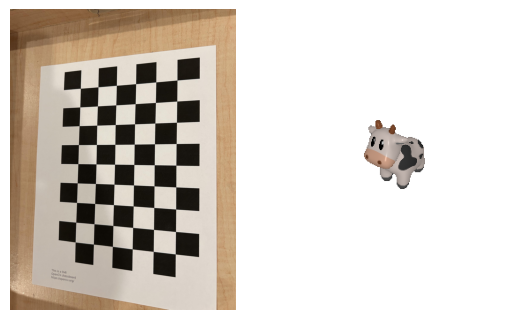

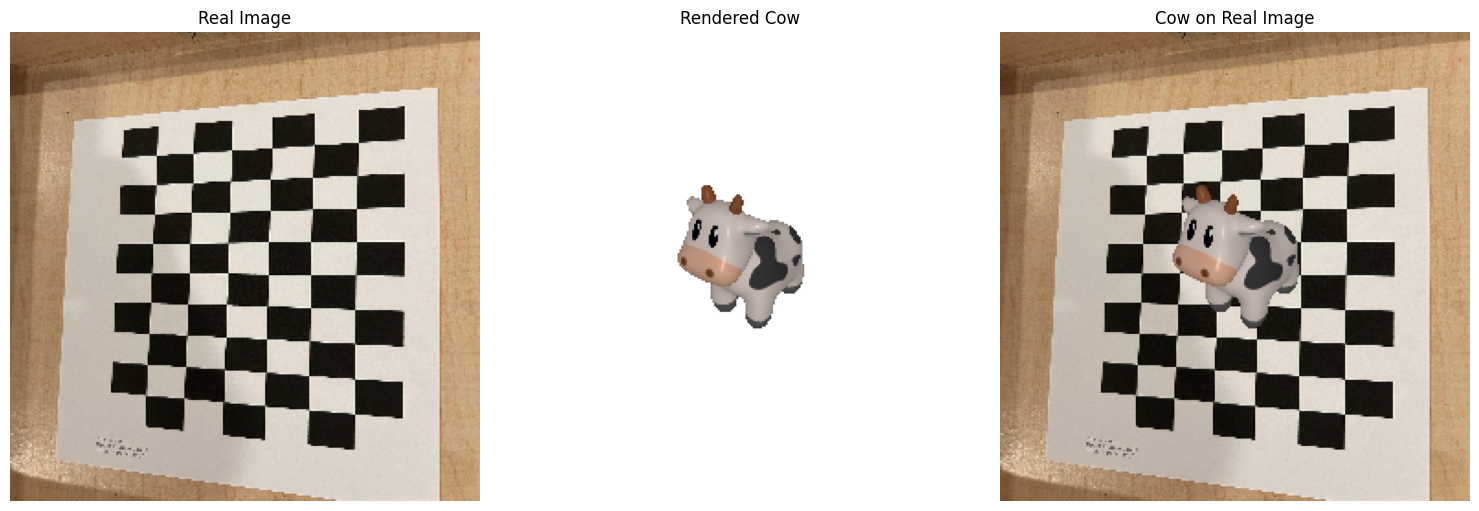

In [31]:
# Image size
W = 256
H = 256

# Create general (Soft) Phong renderer
phong_renderer = make_phong_renderer(W, H, device)

# Define the plane's pose
R_plane = np.array([[ 0.95126525, -0.02257178, 0.30754666],
                    [ 0.00767229, 0.9987412, 0.04956966],
                    [ -0.30827839, -0.04479431, 0.95024097]])
T_plane = np.array([[-2.0877786],
                    [-3.81997439],
                    [12.19733123]])

# Create the transformation matrix for the plane
plane_pose = np.hstack((R_plane, T_plane))
plane_pose = np.vstack((plane_pose, [0, 0, 0, 1]))  # Make it a 4x4 matrix

# Invert the transformation matrix to get the camera pose
camera_pose = np.linalg.inv(plane_pose)

# Extract camera position
camera_position = camera_pose[:3, 3]  # Get the translation part
x, y, z = camera_position

# Convert to spherical coordinates
r = np.sqrt(x**2 + y**2 + z**2)
theta = np.arccos(z / r)  # polar angle
phi = np.arctan2(y, x)    # azimuthal angle

# Convert angles from radians to degrees for PyTorch3D
elev = np.degrees(theta)
azim = np.degrees(phi)

# Set distance based on the spherical radius
distance = r/3

# Pretty printing
#myp3dtools.print_spherical_coords(distance, elev, azim)

# Get the camera pose (Row-major storage)
R, T = look_at_view_transform(distance, elev, azim)

# Pretty print camera information
#myp3dtools.print_camera_pose_matrices(R, T, "PyTorch3D Camera")

# Create camera(s)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Get camera center in world coordinates (handles batches)
light_loc = cameras.get_camera_center()          # shape: (N, 3)

# Create a Lights module at the camera center
lights = PointLights(device=device, location=cameras.get_camera_center())

# Set the renderer state as needed for the image(s)
set_renderer_state(phong_renderer, cameras=cameras, lights=lights)

# Render images
images = phong_renderer(mesh)

rgb_rotated = images[0, ..., :3].cpu().numpy()
rendered_alpha = images[0, ..., 3:4].cpu().numpy()

image_path = os.path.join(calibration_dir, 'test-images', 'image_2.jpeg')

image = cv2.imread(image_path)
# Convert BGR to RGB for matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plot1 = plt.subplot2grid((1, 2), (0, 0))
plot2 = plt.subplot2grid((1, 2), (0, 1))
plot1.imshow(image_rgb)
plot1.axis("off")
plot2.imshow(rgb_rotated)
plot2.axis("off")
plt.show()

# rezised the image
H, W = rgb_rotated.shape[:2]
real_img_resized = cv2.resize(image_rgb, (W, H))
if real_img_resized.max() > 1.0:
    real_img_resized = real_img_resized / 255.0

# Composite
mask = (rendered_alpha > 0.01).astype(float)
composite = mask * rgb_rotated + (1 - mask) * real_img_resized

# Display results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(real_img_resized)
axes[0].set_title("Real Image")
axes[0].axis('off')

axes[1].imshow(rgb_rotated)
axes[1].set_title("Rendered Cow")
axes[1].axis('off')

axes[2].imshow(composite)
axes[2].set_title("Cow on Real Image")
axes[2].axis('off')

plt.tight_layout()
plt.show()

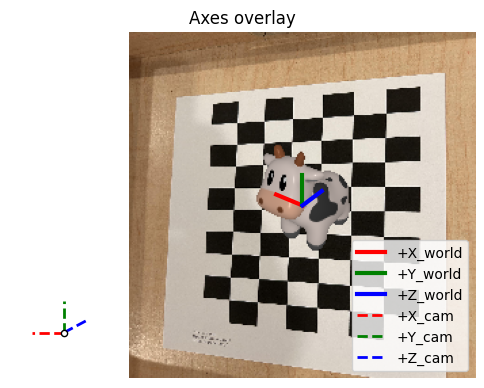

In [32]:
overlay_axes_p3d(composite, cameras, 256, 256,
                 world_origin=(0,0,0), axis_len=0.5,
                 draw_world_axes=True, draw_camera_axes=True,
                 cam_axis_len=0.5,
                 title="Axes overlay")

***Render Multiple Images***

In [ ]:
import json

# Image size
W = 256
H = 256

# Create general (Soft) Phong renderer
phong_renderer = make_phong_renderer(W, H, device)

# Load poses from JSON
with open('poses.json', 'r') as f:
    poses_data = json.load(f)

# Create figure for all results
fig, axes = plt.subplots(len(poses_data), 3, figsize=(15, 5 * len(poses_data)))

for i, pose_data in enumerate(poses_data):
    # Convert lists to numpy arrays
    R_plane = np.array(pose_data['R_plane'])
    T_plane = np.array(pose_data['T_plane'])
    
    # Create the transformation matrix
    plane_pose = np.hstack((R_plane, T_plane))
    plane_pose = np.vstack((plane_pose, [0, 0, 0, 1]))
    
    # Invert to get camera pose
    camera_pose = np.linalg.inv(plane_pose)
    camera_position = camera_pose[:3, 3]
    x, y, z = camera_position
    
    # Convert to spherical coordinates
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z / r)
    phi = np.arctan2(y, x)
    elev = np.degrees(theta)
    azim = np.degrees(phi)
    distance = r/3
    
    # Get camera pose and create camera
    R, T = look_at_view_transform(distance, elev, azim)
    cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
    lights = PointLights(device=device, location=cameras.get_camera_center())
    
    # Set renderer state and render
    set_renderer_state(phong_renderer, cameras=cameras, lights=lights)
    images = phong_renderer(mesh)
    
    rgb_rotated = images[0, ..., :3].cpu().numpy()
    rendered_alpha = images[0, ..., 3:4].cpu().numpy()
    
    # Load and process real image
    image_path = os.path.join('test-images', pose_data['image_file'])
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Resize and composite
    H_img, W_img = rgb_rotated.shape[:2]
    real_img_resized = cv2.resize(image_rgb, (W_img, H_img))
    if real_img_resized.max() > 1.0:
        real_img_resized = real_img_resized / 255.0
    
    mask = (rendered_alpha > 0.01).astype(float)
    composite = mask * rgb_rotated + (1 - mask) * real_img_resized
    
    # Overlay axes on composite
    composite_with_axes = overlay_axes_p3d(
        composite, cameras, 256, 256,
        world_origin=(0,0,0), axis_len=0.5,
        draw_world_axes=True, draw_camera_axes=False,
        cam_axis_len=0.5,
        title=f"Composite {i+1} with axes"
    )
    
    # Display in row i
    axes[i, 0].imshow(real_img_resized)
    axes[i, 0].set_title(f"Real Image {i+1}")
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(rgb_rotated)
    axes[i, 1].set_title(f"Rendered Cow {i+1}")
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(composite_with_axes)
    axes[i, 2].set_title(f"Composite {i+1}")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()